# Import Libraries

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import pandas as pd
import scipy.io
import pickle
from matplotlib.pyplot import figure
from IPython.core.debugger import set_trace
from sklearn.preprocessing import scale
from scipy.special import expit
from scipy.stats import norm
import json
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = 'iframe'

# Load experimental data

In [110]:
# Experimental data
APPNAME = 'shepcons' #simpitchv2
FILTER_EXPERIENCE = True
EXPERIENCE_THRESHOLD = 0 # 3 is a good number
NBOOT = 1000
PATH = f"data/{APPNAME}-data/psynet/data/"
nodes = pd.read_csv(PATH + "node.csv", low_memory=False)
infos = pd.read_csv(PATH + "info.csv", low_memory=False)
networks = pd.read_csv(PATH + "network.csv", low_memory=False)
participants = pd.read_csv(PATH + "participant.csv", low_memory=False)
questions = pd.read_csv(PATH + "question.csv", low_memory=False)


MIN_INTERVAL = 1
MAX_INTERVAL = 11    
list_of_chords = [json.dumps([i,j]) for i in range(MIN_INTERVAL,MAX_INTERVAL+1) for j in range(i,MAX_INTERVAL+1)]
    

# filter networks
network_data = networks
network_data = network_data[network_data["role"] == "experiment"]
network_data = network_data[network_data["failed"] == 'f']
network_data = network_data[network_data["trial_maker_id"] == 'main_experiment']

experiment_net_id = list(network_data['id'].to_numpy())

# filter participants
valid_participants = participants
valid_participants = valid_participants[valid_participants["complete"] == "t"]

# filter based on musical expertise
if FILTER_EXPERIENCE:
    musical_experience = questions[questions["question"] == "years_playing_music"]
    musical_experience = musical_experience[['participant_id','response']]
    musical_experience = musical_experience.assign(
        numeric_response = lambda dataframe: dataframe['response'].map(lambda response: json.loads(response))
    )
    musical_experience = musical_experience[pd.to_numeric(musical_experience['numeric_response'], errors='coerce').notnull()]
    musical_experience['numeric_response'] = musical_experience['numeric_response'].astype(float) #int
    musical_experience = musical_experience[musical_experience['numeric_response'] >= EXPERIENCE_THRESHOLD]
    experienced_ids = list(musical_experience["participant_id"].to_numpy())
    valid_participants = valid_participants[valid_participants["id"].isin(experienced_ids)]

valid_participant_id = list(valid_participants['id'].to_numpy())

# filter trials
trial_data = infos
trial_data = trial_data[trial_data["type"] == "custom_trial"]
trial_data = trial_data[trial_data["failed"] == "f"]
trial_data = trial_data[trial_data["complete"] == "t"]
trial_data = trial_data[trial_data["is_repeat_trial"] == "f"]
trial_data = trial_data[trial_data["network_id"].isin(experiment_net_id)]
trial_data = trial_data[trial_data["participant_id"].isin(valid_participant_id)]
trial_data = trial_data[["id", "origin_id", "response_id", "network_id", "participant_id", "definition", "answer", "stimulus_id"]]

# create response summary

def extract_from_json(definition, key):
    definition = json.loads(definition)
    return definition[key]

origin_id = trial_data["origin_id"].to_numpy()
participant_id = trial_data["participant_id"].to_numpy()
response_id = trial_data["response_id"].to_numpy()
definition = trial_data["definition"].to_numpy()
definition = [json.loads(el)["chord"] for el in trial_data["definition"].to_numpy()]
answer = trial_data["answer"].to_numpy()
answer = [json.loads(ans) for ans in answer]

f0 = [el["f0"] for el in definition]
synth = [el["synth"] for el in definition]
shepardize = [el["shepardize"] for el in definition]
parametrization = [el["parametrization"] for el in definition]
intervals = [json.dumps(el["intervals"]) for el in definition]
stim_idx = [np.where(np.array(list_of_chords) == chord)[0][0] for chord in intervals]

data = pd.DataFrame({
    "origin_id": origin_id,
    "participant_id": participant_id,
    "response_id": response_id,
    "answer": answer,
    "synth": synth,
    "shepardize": shepardize,
    "parametrization": parametrization,
    "f0": f0,
    "intervals": intervals,
    "stim_idx": stim_idx
})


In [111]:
data

,origin_id,participant_id,response_id,answer,synth,shepardize,parametrization,f0,intervals,stim_idx
0,108,66,5737.0,3,pure,True,bass,65,"[6, 7]",46
1,52,4,888.0,5,pure,True,bass,65,"[2, 9]",18
2,20,12,1005.0,4,pure,True,bass,65,"[1, 3]",2
3,128,67,4454.0,6,pure,True,bass,65,"[8, 8]",56
4,56,3,77.0,7,pure,True,bass,65,"[2, 11]",20
...,...,...,...,...,...,...,...,...,...,...
4945,138,118,8414.0,2,pure,True,bass,65,"[9, 10]",61
4946,140,118,8406.0,1,pure,True,bass,65,"[9, 11]",62
4947,102,116,8418.0,5,pure,True,bass,65,"[5, 10]",43
4948,118,118,8408.0,7,pure,True,bass,65,"[7, 7]",51


# Costs and demograhics

In [8]:
participants = pd.read_csv(PATH + "participant.csv", low_memory=False)
valid_participants = participants[participants["complete"] == "t"]
# valid_participants = valid_participants[valid_participants["failed"] == "f"]
experiment_summary = {
    "N_participants": valid_participants.shape[0],
    "cost": participants["base_pay"].sum() + participants["bonus"].sum()
}

experiment_summary


{'N_participants': 79, 'cost': 148.35}

# Export to CSV

In [9]:
data.to_csv("triads_consonance_shepcons.csv")

# Preprocess data

In [133]:
Z_SCORE = False

# to get number of participants
part = data['participant_id']
print(np.max(part))

def preprocess_data(data, list_of_chords, z_score):
    N = len(list_of_chords) # 81
    consonance = np.zeros(shape=(N,))

    if not z_score:
        processed = data[["intervals", "answer", "stim_idx"]]
        processed = processed.groupby(["intervals", "stim_idx"],as_index=False).mean()
        
        for i in range(len(processed.index)):
            idx = processed["stim_idx"][i]
            consonance[idx] = processed["answer"][i]
    
    return consonance

consonance = preprocess_data(data, list_of_chords, Z_SCORE)


124


# Consonace Difference Data
Sorted by difference for pairs of chords

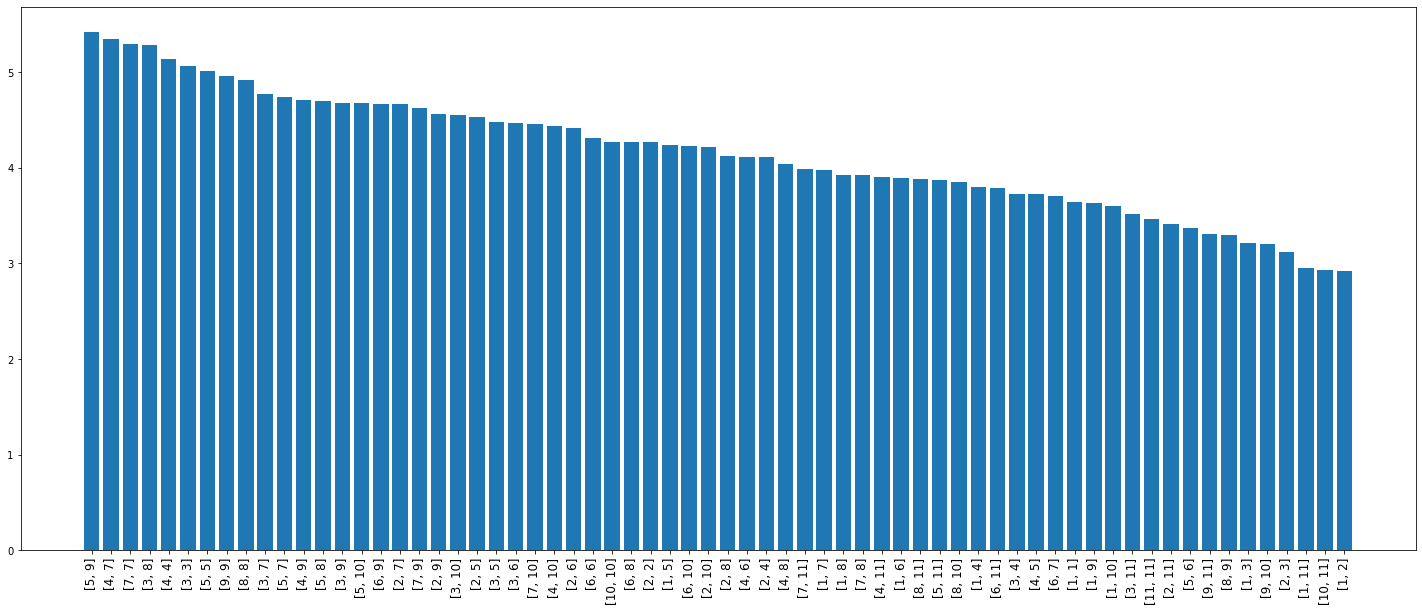

In [11]:
arr1inds = consonance.argsort()

fig, ax = plt.subplots(1, 1, figsize = (25,10))
ax.bar(np.array(list_of_chords)[arr1inds[::-1]], consonance[arr1inds[::-1]])
# ax.set_xticks([i for i in range(len(list_of_chords))], list_of_chords, rotation = 90)
ax.tick_params(axis='x', which='major', labelsize=12, rotation = 90)

[[1.         0.55233439 0.44525326 ... 0.65102976 0.56928789 0.42732213]
 [0.49933333 1.         0.65498994 ... 0.27819314 0.36115748 0.47246658]
 [0.33611636 0.5180395  1.         ... 0.49236138 0.25549332 0.47834979]
 ...
 [0.51612099 0.0995222  0.19990967 ... 1.         0.41067603 0.68511045]
 [0.39958071 0.55494624 0.5990514  ... 0.54434632 1.         0.52836652]
 [0.57728258 0.45105985 0.29971688 ... 0.7565535  0.45083919 1.        ]]


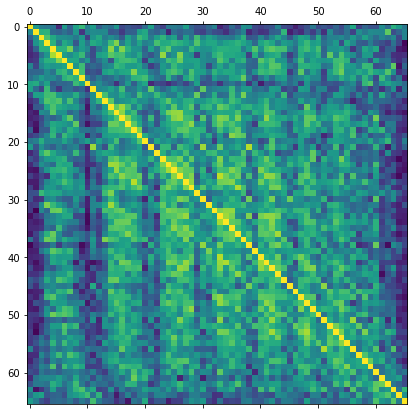

In [106]:
sim_mat = np.load("asymmetric_shepchordf2_shepchord2.npy") # load triad simialrity data, without averaging over order
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.matshow(sim_mat)

In [13]:
consonance_delta = []
fitness = []
chord_transition = []

for i in range(len(list_of_chords)):
    for j in range(len(list_of_chords)):
        if j!=i:
            consonance_delta.append(consonance[j] - consonance[i])
            fitness.append(sim_mat[i, j])
            chord_transition.append([list_of_chords[i],list_of_chords[j]])

consonance_delta = np.array(consonance_delta)
fitness = np.array(fitness)

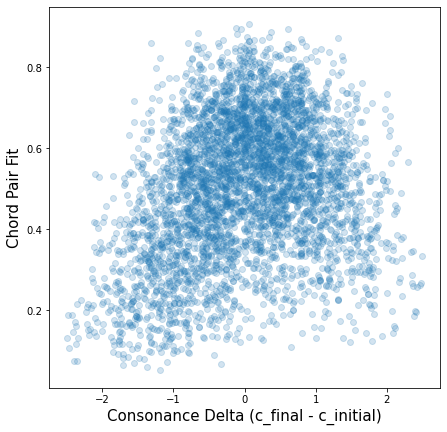

In [14]:
from scipy.stats import pearsonr

fig, ax = plt.subplots(1, 1, figsize = (7,7))
ax.scatter(consonance_delta, fitness, alpha = 0.2)
ax.set_xlabel("Consonance Delta (c_final - c_initial)", fontsize = 15);
ax.set_ylabel("Chord Pair Fit", fontsize = 15);

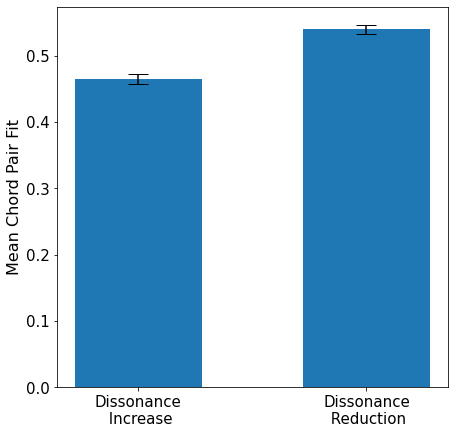

In [15]:
conditions = ["Dissonance\n Increase", "Dissonance\n Reduction"]

fitness_mean = np.array([np.mean(fitness[consonance_delta < 0]), np.mean(fitness[consonance_delta > 0])])
fitness_std= np.array([np.std(fitness[consonance_delta < 0]) / np.sqrt(len(fitness[consonance_delta < 0])),
               np.std(fitness[consonance_delta > 0]) / np.sqrt(len(fitness[consonance_delta > 0]))])

fig, ax = plt.subplots(1, 1, figsize = (7,7))
x_pos = [0, 0.9]
ax.bar(x_pos, fitness_mean, yerr=1.96 * fitness_std, align='center', capsize=10, width = 0.5)
ax.set_xticks(x_pos);
ax.set_xticklabels(conditions, fontsize = 15);
ax.tick_params(axis='y', which='major', labelsize=15);
ax.set_ylabel("Mean Chord Pair Fit", fontsize = 16);

# Load symmetrized triad data

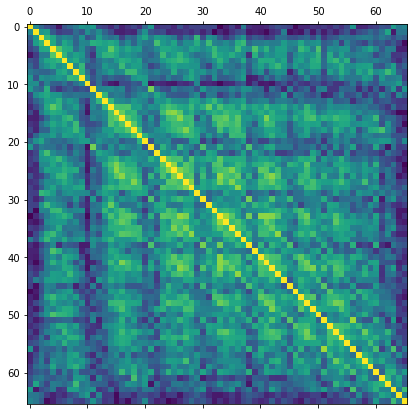

In [16]:
data = pd.read_csv("merged_datasets_shepchord2_shepchordf_sym.csv")

sym_mat = np.load("symmetric_shepchord2_shepchordf2.npy") # load triad simialrity data, with averaging over order
fig, ax = plt.subplots(1, 1, figsize = (7,7))

ax.matshow(sym_mat)

# Voice-leading Distance Functions

In [104]:
ROOT = 65
# fitness: data on how well two chords "fit together"
# consonance_delta: has difference in consonance ratings
# chord_transition : pairs of dyads on top of root of 65


def compute_wrapped_distance(chord1, chord2, p):
    # add root
    chord1 = np.array([ROOT, chord1[0], chord1[1]])
    chord2 = np.array([ROOT, chord2[0], chord2[1]])
    # inversions of chord2
    chord2_2 = np.array([chord2[2],chord2[1],chord2[0]])
    chord2_3 = np.array([chord2[2],chord2[0],chord2[1]])
    chord2_4 = np.array([chord2[1],chord2[0],chord2[2]])
    chord2_5 = np.array([chord2[1],chord2[2],chord2[0]])
    chord2_6 = np.array([chord2[0],chord2[2],chord2[1]])
    inversions = np.array([chord2, chord2_2, chord2_3, chord2_4, chord2_5, chord2_6])
    
    diffs = []
    for i in range(len(inversions)) :
        diff = np.mod(np.abs(chord1 - inversions[i]), 12)
        for j in range(len(diff)) :
            if diff[j] > 6 :
                diff[j] = 12 - diff[j]
        diffs = diffs + [diff]
        
    diffs = np.power(diffs, p)
    sums = np.sum(diffs, axis=1)
    return np.amin(sums) ** (1/p)

def compute_distance(c1, c2, p):
    # root is the same for both
    c1 = np.power(c1, p)
    c2 = np.power(c2, p)
    v = np.sum(np.abs(c1-c2))
    return v ** (1/p)




dists = []
wrapped_dists = []
P = 1
for i in range(len(chord_transition)):
        w_diff = compute_wrapped_distance(np.array(json.loads(chord_transition[i][0]))+59, 
                                        np.array(json.loads(chord_transition[i][1]))+59, P)
        diff = compute_distance(np.array(json.loads(chord_transition[i][0])), 
                                        np.array(json.loads(chord_transition[i][1])), P)
        wrapped_dists = wrapped_dists + [w_diff]
        dists = dists + [diff]

# Standard Voice-leading Distance Analysis
As a baseline

Slope:  -0.023242727402013344 , y-intercept:  0.6449668148193473 r-value:  -0.4675283801575029 
 p-value:  5.711030900094778e-232 variance:  0.007881167787378221


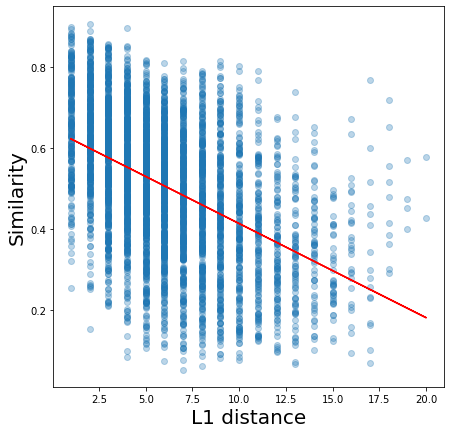

In [130]:
fit = scipy.stats.linregress(dists, fitness)

fig, ax = plt.subplots(1,1,figsize = (7,7))

pred_fit = np.multiply(dists, fit[0]) + fit[1]
ax.plot(dists, pred_fit, color = "RED")
ax.scatter(dists, fitness, alpha = 0.3)

dist_var = np.var(abs(pred_fit-fitness))

ax.set_xlabel("L1 distance", fontsize = 20)
ax.set_ylabel("Similarity", fontsize = 20)
print("Slope: ", fit[0], ", y-intercept: ", fit[1], "r-value: ", fit[2], 
      "\n p-value: ", fit[3], "variance: ", dist_var)

# Minimal Voice-leading Distance Analysis

Slope:  -0.03908293661423861 , y-intercept:  0.69700618141104 r-value:  -0.5120587370782521 
 p-value:  1.703777852656625e-285 variance:  0.00737567483301299


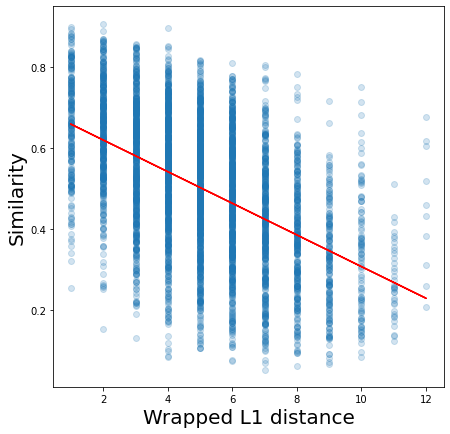

In [131]:
fit = scipy.stats.linregress(wrapped_dists, fitness)

fig, ax = plt.subplots(1,1,figsize = (7,7))

pred_fit = np.multiply(wrapped_dists, fit[0]) + fit[1]
ax.plot(wrapped_dists, pred_fit, color = "RED")
ax.scatter(wrapped_dists, fitness, alpha = 0.2)

dist_var = np.var(abs(pred_fit-fitness))

ax.set_xlabel("Wrapped L1 distance", fontsize = 20)
ax.set_ylabel("Similarity", fontsize = 20)
print("Slope: ", fit[0], ", y-intercept: ", fit[1], "r-value: ", fit[2], 
      "\n p-value: ", fit[3], "variance: ", dist_var)

# Absolute Consonance Difference Analysis

In [2]:
consonance = np.absolute(consonance_delta)

fit = scipy.stats.linregress(consonance, fitness)

fig, ax = plt.subplots(1,1,figsize = (7,7))

cons_fit = np.multiply(consonance, fit[0]) + fit[1]
ax.plot(consonance, cons_fit, color = "RED")
ax.scatter(consonance, fitness, alpha = 0.2)

cons_var = np.var(abs(cons_fit-fitness))

ax.set_xlabel("Absolute Difference in Consonance", fontsize = 20)
ax.set_ylabel("Similarity", fontsize = 20)
print("Slope: ", fit[0], ", y-intercept: ", fit[1], "r-value: ", fit[2], 
      "\n p-value: ", fit[3], "variance: ", cons_var)

NameError: name 'np' is not defined

# Gaussian Consonance Difference Optimization and Analysis
No performance difference when optimizing for sigma

Slope:  1.9749678876570524 , y-intercept:  0.38274122090777685 r-value:  0.367058914636353 
 p-value:  5.903587334767049e-137 variance:  0.00855397851004846 , optimized sigma:  10.0


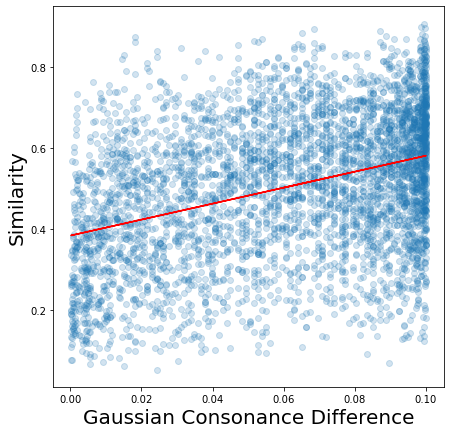

In [123]:
# Gaussian consonance difference
from scipy.optimize import minimize

# objective function to optimize sigma
def gauss_opt(sigma) :
    gaussian_diffs = np.exp(-np.power(consonance_delta,2)) / sigma
    fit = scipy.stats.linregress(gaussian_diffs, fitness)
    gsims = np.multiply(gaussian_diffs, fit[0]) + fit[1]
    return np.linalg.norm(gsims - fitness)

guess_sigma = 10
result = minimize(gauss_opt, guess_sigma)

# Gaussian differences in consonance rating
best_gauss = np.exp(-np.power(consonance_delta,2)) / result['x'][0]


fit = scipy.stats.linregress(best_gauss, fitness)

# similarities predicted by optimized Gaussian difference
gauss_fit = np.multiply(best_gauss, fit[0]) + fit[1]

gauss_var = np.var(abs(gauss_fit-fitness))



fig, ax = plt.subplots(1,1,figsize = (7,7))
ax.plot(best_gauss, gauss_fit, color = "RED")
ax.scatter(best_gauss, fitness, alpha = 0.2)

ax.set_xlabel("Gaussian Consonance Difference", fontsize = 20)
ax.set_ylabel("Similarity", fontsize = 20)
print("Slope: ", fit[0], ", y-intercept: ", fit[1], "r-value: ", fit[2], 
      "\n p-value: ", fit[3], "variance: ", gauss_var, ", optimized sigma: ", result['x'][0])

# Combined Model Analysis
Linear regression of two variables using minimal voice-leading distance and absolute consonance difference data as predictors for perceived similarity data.

Distance contribution:  -0.034613785002409456 , Gaussian Consonance Difference contribution:  -0.09772227367296864 , 
 r-value:  0.5878095492167202 , variance:  0.006710324595172946


Text(0, 0.5, 'Absolute Consonance Difference')

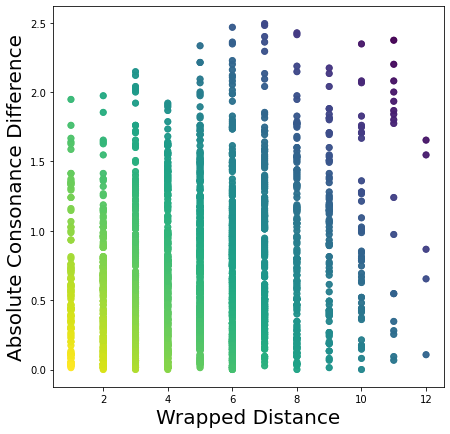

In [126]:
from sklearn import linear_model
mixture = linear_model.LinearRegression()
mixture.fit(np.array([wrapped_dists,consonance]).T, fitness)

mix_pred_fit = np.multiply(wrapped_dists,mixture.coef_[0]) + np.multiply(consonance,mixture.coef_[1]) + mixture.intercept_
mix_r = np.sqrt(mixture.score(np.array([wrapped_dists,consonance]).T, fitness))
mix_var = np.var(abs(mix_pred_fit-fitness))

print("Distance contribution: ", mixture.coef_[0], ", Gaussian Consonance Difference contribution: ", 
      mixture.coef_[1], ", \n r-value: ", mix_r, ", variance: ", mix_var)

fig, ax = plt.subplots(1,1,figsize = (7,7))
ax.scatter(wrapped_dists, consonance,c=mix_pred_fit,  alpha = 0.8)
ax.set_xlabel("Wrapped Distance", fontsize = 20)
ax.set_ylabel("Absolute Consonance Difference", fontsize = 20)


# Spectral Pitch-class Distance Function

In [125]:

C = 60
rho = 0.6
sigma = 1
harmonic_series = np.array([0, 1200, 700, 500, 400, 300, 300, 200, 200, 200, 200, 100])

# converts single tone to frequency vector representation
def note_to_vec(note, rho) :
    idx = ((note - C) * 100) % 1200
    harm = np.zeros(1200)
    for i in range(len(harmonic_series)) :
        idx += harmonic_series[i]
        idx %= 1200
        harm[idx] = (i+1)**-rho
    return harm

# weight vector for the root 65 or F
ROOT_VEC = note_to_vec(ROOT, rho)

# caclulates spectral distance between two chords
# rho = shrinking factor of successive harmonics
# sigma = variance of smeared distribution
def spectral_dist(chord1, chord2, rho, sigma) :
    # for each note, get row vector representation
    x_wt = ROOT_VEC
    y_wt = ROOT_VEC
    for i in range(2) :
        x_wt = x_wt + note_to_vec(chord1[i], rho)
        y_wt = y_wt + note_to_vec(chord2[i], rho)
        
    smear = np.random.normal(0, sigma, 1200)
    x_e = np.convolve(x_wt, smear)
    y_e = np.convolve(y_wt, smear)
    
    xy = x_e @ y_e
    xx = x_e @ x_e
    yy = y_e @ y_e
    
    return 1 - (xy / np.sqrt(xx * yy))
    


specs = []

for i in range(len(chord_transition)):
        spec = spectral_dist(np.array(json.loads(chord_transition[i][0])), 
                                        np.array(json.loads(chord_transition[i][1])), rho, sigma)
        specs = specs + [spec]

# Spectral Pitch-class Plot

Text(0, 0.5, 'Similarity')

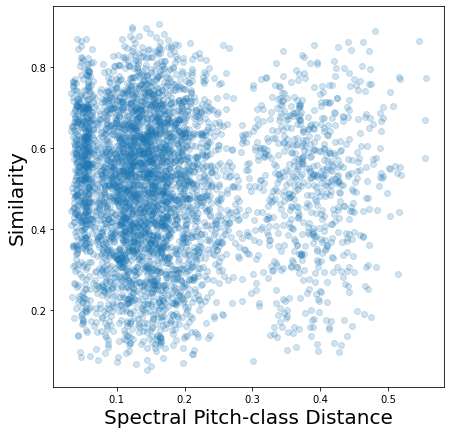

In [83]:
fit = scipy.stats.linregress(specs, fitness)

fig, ax = plt.subplots(1,1,figsize = (7,7))



ax.scatter(specs, fitness, alpha = 0.2)

spec_var = np.var(abs(spec_fit-fitness))

ax.set_xlabel("Spectral Pitch-class Distance", fontsize = 20)
ax.set_ylabel("Similarity", fontsize = 20)
